#### Import Module

In [1]:
import pandas as pd
import numpy as np
from util.data_management import concate_data, load_data_raw, display_data, data_to_fft, data_adjust_scale, data_reshape_for_train, data_split_to_chunk
from util.data_generator_AE import DataGenerator
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn import metrics
from easydict import EasyDict
import time
import os

#### GPU Set & Check

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

#### Set argument

In [3]:
args = EasyDict({
    'dir_path' : r"D:\Anomaly-Dataset", ## 1: C:\Users\VIP444\Documents\Anomaly-Dataset, 2: D:\Anomaly-Dataset\sar400_vibration_data
    'is_normal' : True,
    'is_train' : True,
    'stop_idx' : 2,
    'data_scale_fit' : True,
    'data_scale_trans' : False,
    'batch_size' : 256,
    'split' : (0.9, 0.1),
    'is_cache' : True,
    'is_predict' : True,
    'is_normalize' : False,
    'is_lstm' : True,
    'model_name' : 'LSTM'
})

#### DataGenerator

In [4]:
train_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Train',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

validation_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Validation',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

test_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Test',
    batch_size=args.batch_size,
    split=args.split,
    is_train=False,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm,
    is_predict=args.is_predict
)

#### Check dataset length

In [5]:
print(len(train_dataset.data_paths))
print(len(validation_dataset.data_paths))
print(len(test_dataset.data_paths))

7034
782
4276


#### Model Create & Compile

In [29]:
from models.ae_LSTM import autoencoder_model
# from models.ae_Dense import autoencoder_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

if args.is_lstm:
    input_shape = (1, 4)
else:
    input_shape = (4, )

model = autoencoder_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=Huber(), metrics=['mae'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 64)             17664     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 32)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 64)             24832     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 4)              260 

#### Model Train

In [30]:
epochs = 200

EXPERIMENT_DIR = f"./training_logs/{time.strftime('%Y-%m-%d-%H%M%S')}-{args.model_name}"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

checkpoint_path = EXPERIMENT_DIR + "/model/checkpoint.pt"
os.makedirs(EXPERIMENT_DIR + "/model", exist_ok=True)

callbacks = [
    # EarlyStopping(monitor='val_mae', patience=7, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.8, patience=6,verbose=1, min_lr=1e-3 * 1e-1),
    CSVLogger(EXPERIMENT_DIR + '/train_log.csv', separator=',', append=True),
    ]

history = model.fit(train_dataset, validation_data=(validation_dataset), epochs=epochs, batch_size=args.batch_size, callbacks=callbacks).history
model.load_weights(checkpoint_path)
model.save(EXPERIMENT_DIR + "/model/model.h5")

Epoch 1/200
28/28 [==============================] - 3s 35ms/step - loss: 0.9262 - mae: 1.3213 - val_loss: 1.4157 - val_mae: 1.8314

Epoch 00001: val_mae improved from inf to 1.83137, saving model to ./training_logs/2022-06-24-122957-LSTM/model\checkpoint.pt
Epoch 2/200
28/28 [==============================] - 1s 21ms/step - loss: 0.8638 - mae: 1.2429 - val_loss: 1.2009 - val_mae: 1.5879

Epoch 00002: val_mae improved from 1.83137 to 1.58785, saving model to ./training_logs/2022-06-24-122957-LSTM/model\checkpoint.pt
Epoch 3/200
28/28 [==============================] - 1s 21ms/step - loss: 0.4621 - mae: 0.7855 - val_loss: 0.8024 - val_mae: 1.2167

Epoch 00003: val_mae improved from 1.58785 to 1.21675, saving model to ./training_logs/2022-06-24-122957-LSTM/model\checkpoint.pt
Epoch 4/200
28/28 [==============================] - 1s 20ms/step - loss: 0.1614 - mae: 0.4393 - val_loss: 0.6804 - val_mae: 1.1043

Epoch 00004: val_mae improved from 1.21675 to 1.10428, saving model to ./training_

#### Visualize Learning Tendency

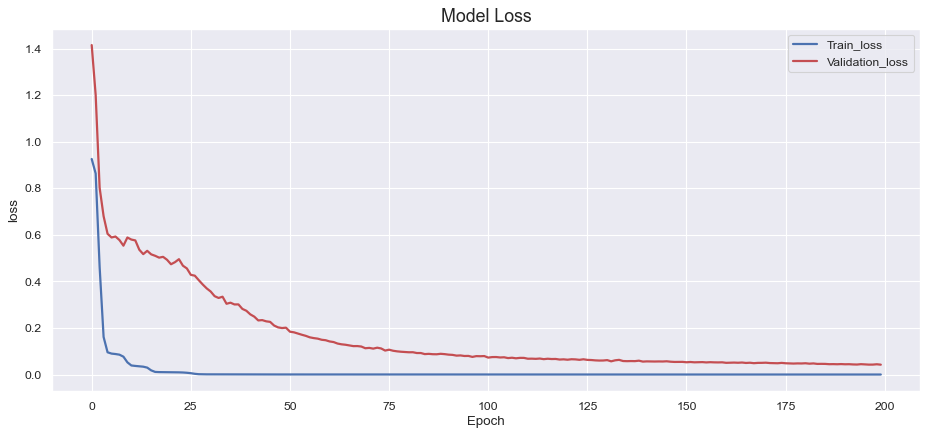

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

#### Model evaluate

In [ ]:
loss = model.evaluate(test_dataset, verbose=1)
print(loss)

#### Predict Test dataset

In [32]:
predict = model.predict(test_dataset, verbose=1)
print(predict.shape)

17/17 [==============================] - 0s 4ms/step
(4276, 1, 4)


#### Predict Validation dataset for calculate threshold

In [33]:
validation_dataset.is_predict = True
predict_val = model.predict(validation_dataset, verbose=1)
print(predict_val.shape)

4/4 [==============================] - 0s 7ms/step
(782, 1, 4)


#### Predict data reshape for analysis

In [34]:
predict = predict.reshape(predict.shape[0], predict.shape[2])
predict_val = predict_val.reshape(predict_val.shape[0], predict_val.shape[2])

print(predict.shape)
print(predict_val.shape)

(4276, 4)
(782, 4)


#### Load original validation data

In [35]:
keys = list(validation_dataset.cache.keys())

validation_data = np.array([row for key in keys for row in validation_dataset.cache[key][0]])
validation_data = validation_data.reshape(validation_data.shape[0], validation_data.shape[2])
print(validation_data.shape)

(782, 4)


#### Calculate threshold use precision_recall_curve

1.0
1.0
0.06527588021351174


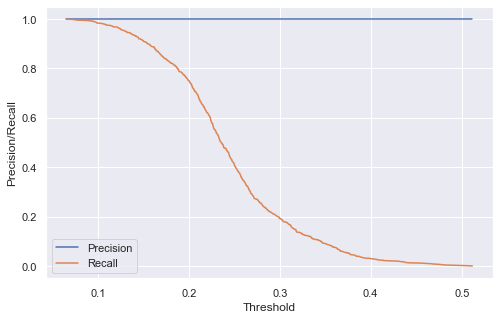

In [36]:
# mse = np.mean(np.power(validation_data - predict_val, 2), axis=1)
mae = np.mean(np.abs(validation_data - predict_val), axis=1)

y_valid = np.ones(len(validation_data))

error_df = pd.DataFrame({'Reconstruction_error' : mae, 'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
# model = tf.keras.models.load_model('model/model_loss_test.h5')

# X_pred = model.predict(X_train)

# X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
# X_pred = pd.DataFrame(X_pred)

# Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

# scored = pd.DataFrame()
# scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# # scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

# Threshold = 0.017

# plt.figure(figsize=(16,9), dpi=80)
# plt.title('Loss Distribution', fontsize=16)
# plt.xlim([0,1])
# sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

#### Predict data to log.csv

In [37]:
X_pred = pd.DataFrame(predict)

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = threshold*2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv(EXPERIMENT_DIR + '/test_log.csv', sep=',')

      Loss_mae  Threshold  Anomaly
0     8.290551   0.130552     True
1     7.784816   0.130552     True
2     8.667360   0.130552     True
3     8.471788   0.130552     True
4     7.292924   0.130552     True
...        ...        ...      ...
4271  5.101452   0.130552     True
4272  4.395678   0.130552     True
4273  4.548359   0.130552     True
4274  4.561957   0.130552     True
4275  4.669736   0.130552     True

[4276 rows x 3 columns]


In [38]:
X_pred_val = pd.DataFrame(predict_val)

scored_val = pd.DataFrame()
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-validation_data), axis=1)
scored_val['Threshold'] = threshold*2
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)
scored_val.to_csv(EXPERIMENT_DIR + '/validation_log.csv', sep=',')

     Loss_mae  Threshold  Anomaly
0    0.252387   0.130552     True
1    0.312185   0.130552     True
2    0.171910   0.130552     True
3    0.135598   0.130552     True
4    0.247658   0.130552     True
..        ...        ...      ...
777  0.157781   0.130552     True
778  0.241093   0.130552     True
779  0.260133   0.130552     True
780  0.280981   0.130552     True
781  0.312199   0.130552     True

[782 rows x 3 columns]


In [39]:
np.mean(scored_val['Loss_mae'])

0.2434173008305248